# Final Exam: Hands-On Component

This assignment is worth 10% of the final grade (i.e., 50% of the final exam). Please read carefully the following general instructions:

- You have 24 hours to submit your answers (from the moment you started the assignment in Canvas) or until December 16th at 11:59 pm, whichever occurs first. Late submissions won't be accepted.
- As opposed to previous assignments, the professor and the TA will not provide any guidelines on how to solve this assignment.
- You must complete this assignment individually. The punishment for violating this rule is failing the course.
- You must not share the assignment's details or your solution with anyone. The punishment for violating this rule is failing the course.


# Background

You have been hired by the Iron Bank of Braavos (IBB) to improve the sales of their call center. IBB has launched several marketing campaigns in which call-center employees call the bank customers to offer them banking products. IBB's major concern is how to efficiently assign customer support agents across dozens of campaigns. The cost per minute of a call made from the call center is estimated to be \\$1, and typical campaigns generate \\$0.1 in profits per minute. 

Your job is to decide which customers to call for the rest of one of the current campaigns, in which credit card insurance is being sold. This insurance product is entirely new, and for now, it is only offered to customers that are contacted by IBB. IBB estimates that the sale of each insurance will generate \\$15 in profit after considering all costs not related to the call center.  You have data from a random sample of customers that were called as part of the current campaign, which can be found in the file “insurance-sample.csv”. See the data description below.

|Variable|	Description|
|---|---|
|Id|	Customer’s unique ID.|
|Age|	Customer’s age.|
|Job|	Customer’s job.|
|Marital|	Customer’s marital status.|
|Education|	Customer’s education level.|
|Default|	Whether the customer has credit in default.|
|Balance|	Average annual balance of the customer in $.|
|HHInsurance|	Whether the customer has his/her house insured.|
|CarLoan|	Whether the customer has a vehicle loan.|
|Communication|	Means of communication with the customer.|
|CallDurationSecs|	Duration of the call (in seconds).|
|CardInsurance|	Whether the customer bought the credit card insurance after the call.| 



# Assignment

Build a data science solution to decide which customers in "insurance-use.csv" to contact. Your decisions must be uploaded to Canvas in a file called "decisions.csv". The first column must have the header "Id" and contain the ID of all the customers in "insurance-use.csv". The second column must have the header "decision" and contain your decisions for all these customers: use a 1 for customers you decide to contact and a 0 for customers you decide not to contact. For an example of how to produce a file with these characteristics, see the code below. **IMPORTANT**: You will receive no credits if the file you upload does not follow these guidelines, so please be careful.

Your grade will depend on the quality of your decisions compared to your classmates. Based on the information provided above, you must use your best judgement to determine what a "good quality" decision is. Have fun.

## Preparation

In [1]:
import pandas as pd
import seaborn as sns
import math
import statsmodels.api as sm
from pandas.core.common import random_state
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression 
import numpy as np

In [2]:
data = pd.read_csv("insurance-sample.csv")
data.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,CallDurationSecs,CardInsurance
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.0000,3500.000000
mean,1750.500000,41.227429,0.014857,1541.766000,0.493714,0.135429,350.5560,0.400571
std,1010.507298,11.560655,0.120998,3608.089238,0.500032,0.342230,367.7696,0.490084
min,1.000000,18.000000,0.000000,-3058.000000,0.000000,0.000000,2.0000,0.000000
25%,875.750000,32.000000,0.000000,115.500000,0.000000,0.000000,111.7500,0.000000
50%,1750.500000,39.000000,0.000000,555.000000,0.000000,0.000000,230.0000,0.000000
75%,2625.250000,49.000000,0.000000,1619.250000,1.000000,0.000000,458.2500,1.000000
max,3500.000000,92.000000,1.000000,98417.000000,1.000000,1.000000,3533.0000,1.000000


### Parameter Transformation

Default is very skewed, very small number are 1.

<AxesSubplot:xlabel='Age', ylabel='Count'>

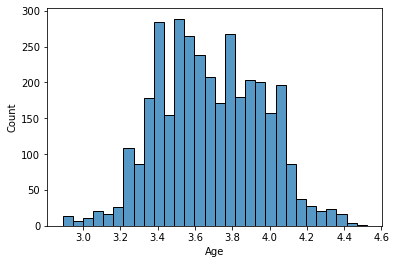

In [4]:
data['Age'] = data['Age'].apply(lambda x: math.log(x))
sns.histplot(data['Age'])

<AxesSubplot:xlabel='Balance', ylabel='Count'>

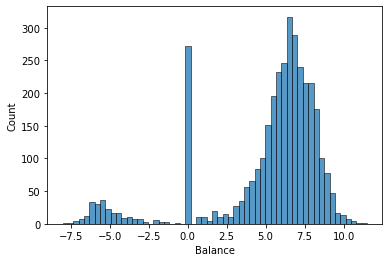

In [5]:
data['Balance'] = data['Balance'].apply(lambda x: math.log(x) if x>0 else 0 if x==0 else -math.log(-x))
sns.histplot(data['Balance'])

In [6]:
data = pd.get_dummies(data, columns=['Job','Marital','Education','Communication'], drop_first=True) 
data['profit'] = data['CardInsurance'] * 15 - data['CallDurationSecs'] / 60 * 0.9

In [7]:
data.drop(columns=['CallDurationSecs','CardInsurance','Id'], inplace=True)

In [8]:
(data['profit'] > 0).mean()

0.3445714285714286

### Train-Test Seperation

In [9]:
train_set = data.iloc[:int(len(data)*0.8),]
test_set = data.iloc[int(len(data)*0.8):, ]

X_train = train_set.iloc[:,:-1]
y_train = train_set.iloc[:,-1]
X_test = test_set.iloc[:,:-1]
y_test = test_set.iloc[:,-1]

y_tr = pd.DataFrame(y_train)
y_tr['judge'] = y_train>0

y_te = pd.DataFrame(y_test)
y_te['judge'] = y_test>0

In [10]:
y_test[y_test>0].sum()

1965.54

## Regression

### Multiple Linear Regression

In [11]:
model1 = sm.OLS(y_train,sm.add_constant(X_train))
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     10.63
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           3.17e-34
Time:                        15:10:22   Log-Likelihood:                -9192.1
No. Observations:                2800   AIC:                         1.843e+04
Df Residuals:                    2778   BIC:                         1.856e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/Users/yilingluo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
predict1 = results1.predict(sm.add_constant(X_test))
predict1[predict1>0].sum()

/Users/yilingluo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


775.7178382876898

In [13]:
call = predict1 > 0
false_positive = (call == True) & (y_te['judge'] == False)    
false_negative = (call == False) & (y_te['judge'] == True)
fp_error_rate = false_positive.mean()
fn_error_rate = false_negative.mean()
print(f"False_positive:{fp_error_rate*100:,.2f}%")
print(f"False_negative:{fn_error_rate*100:,.2f}%")

False_positive:39.86%
False_negative:6.29%


In [14]:
y_test[call == True].sum()

822.9449999999999

In [15]:
call.mean()

0.6671428571428571

### Other Advanced Regression Methods

In [16]:
# Algorithms
ridge_algorithm = Ridge()
lasso_algorithm = Lasso()
tree_algorithm = DecisionTreeRegressor()

# Grids
lin_grid = {"alpha": [10**i for i in np.arange(0, 5, 0.5)]}
tree_grid = {"min_samples_leaf": range(1, 67, 3), 
             "criterion":['friedman_mse']#'squared_error', 'absolute_error', 
             }

# Conduct grid searches
tree_searcher = GridSearchCV(tree_algorithm, tree_grid, cv=10, scoring = 'r2')
ridge_searcher = GridSearchCV(ridge_algorithm, lin_grid, cv=10, scoring = 'r2')
lasso_searcher = GridSearchCV(lasso_algorithm, lin_grid, cv=10, scoring = 'r2')

# Report results
best_algorithm = None
best_score = None
for searcher in [tree_searcher, ridge_searcher, lasso_searcher]: 
    searcher.fit(X_train, y_train)
    print(f"Algorithm : {type(searcher.best_estimator_)}")
    print(f"Best parameters: {searcher.best_params_}")
    print(f"Best score: {searcher.best_score_:.2f}")
    print(f"Total Profit: {y_test[searcher.best_estimator_.predict(X_test)>0].sum()}")
    print("--------")
    if best_algorithm is None or best_score < searcher.best_score_:
        best_algorithm = searcher.best_estimator_
        best_paras = searcher.best_params_
        best_score = searcher.best_score_

Algorithm : <class 'sklearn.tree._classes.DecisionTreeRegressor'>
Best parameters: {'criterion': 'friedman_mse', 'min_samples_leaf': 55}
Best score: 0.06
Total Profit: 635.0699999999999
--------
Algorithm : <class 'sklearn.linear_model._ridge.Ridge'>
Best parameters: {'alpha': 100.0}
Best score: 0.06
Total Profit: 780.03
--------
Algorithm : <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Best parameters: {'alpha': 1.0}
Best score: 0.01
Total Profit: 559.14
--------


## Classification

### Logistic Regression

In [17]:
algorithm = LogisticRegression()
model2 = algorithm.fit(X_train, y_tr['judge'])
probabilities = model2.predict_proba(X_test)[:,1]
#probabilities

/Users/yilingluo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
profit = 0
threshold = 0
for i in range(0,100):
    call = probabilities > i/100
    if(y_test[call == True].sum() > profit):
        profit = y_test[call == True].sum()
        threshold =  i/100

In [19]:
print(profit)
print(threshold)

799.3500000000001
0.44


In [20]:
call = probabilities > threshold
call.mean()

0.29

In [21]:
false_positive = (call == True) & (y_te['judge'] == False)    
false_negative = (call == False) & (y_te['judge'] == True)
fp_error_rate = false_positive.mean()
fn_error_rate = false_negative.mean()
print(f"False_positive:{fp_error_rate*100:,.2f}%")
print(f"False_negative:{fn_error_rate*100:,.2f}%")

False_positive:11.71%
False_negative:15.86%


In [22]:
y_te['judge'].mean()

0.3314285714285714

### Other Advanced Classification

In [23]:
# Algorithms
Tree_algorithm = DecisionTreeClassifier() 
logreg = LogisticRegression()

# Grids
tree_grid = {"min_samples_leaf": [2, 4, 8, 16, 32, 64], 
             'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy'], 
             'random_state': [0]
             }
log_grid={"C":np.logspace(-10,3,2)}

# Conduct grid searches, since the units of money lost or earned are the same, the costs of FP&FN are considered the same
tree_searcher = GridSearchCV(Tree_algorithm, tree_grid, cv=5, scoring = 'accuracy')
logreg_cv=GridSearchCV(logreg, log_grid, cv=5, scoring = 'accuracy')

# Report results
best_algorithm_C = None
best_score = None
for searcher in [tree_searcher, logreg_cv]:
    searcher.fit(X_train, y_tr['judge'])
    print(f"Algorithm : {type(searcher.best_estimator_)}")
    print(f"Best parameters: {searcher.best_params_}")
    print(f"Best score (negative custom error): {searcher.best_score_:.2f}")
    print(f"Profit: {y_test[searcher.best_estimator_.predict(X_test)>0].sum():.2f}")
    print("--------")
    if best_algorithm_C is None or best_score < searcher.best_score_:
        best_algorithm_C = searcher.best_estimator_
        best_paras = searcher.best_params_
        best_score = searcher.best_score_

Algorithm : <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Best parameters: {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 16, 'random_state': 0}
Best score (negative custom error): 0.69
Profit: 786.62
--------


/Users/yilingluo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yilingluo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Algorithm : <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best parameters: {'C': 1000.0}
Best score (negative custom error): 0.68
Profit: 550.93
--------


/Users/yilingluo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yilingluo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

## Result

In [43]:
df_deploy = pd.read_csv("insurance-use.csv")
df_deploy

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication
0,3501,27,admin.,single,secondary,0,1327,0,0,cellular
1,3502,32,management,single,tertiary,0,2059,0,0,cellular
2,3503,43,management,married,tertiary,0,2383,0,0,cellular
3,3504,56,unemployed,married,primary,0,3391,0,0,cellular
4,3505,25,entrepreneur,single,tertiary,0,347,0,0,cellular
...,...,...,...,...,...,...,...,...,...,...
495,3996,28,technician,single,tertiary,0,0,1,0,cellular
496,3997,49,admin.,divorced,secondary,0,124,1,1,cellular
497,3998,27,admin.,single,secondary,0,-400,0,1,cellular
498,3999,36,entrepreneur,single,tertiary,0,658,1,0,cellular


In [44]:
df_deploy['Age'] = df_deploy['Age'].apply(lambda x: math.log(x))
df_deploy['Balance'] = df_deploy['Balance'].apply(lambda x: math.log(x) if x>0 else 0 if x==0 else -math.log(-x))

In [45]:
df_deploy = pd.get_dummies(df_deploy, columns=['Job','Marital','Education','Communication'], drop_first=True) 

In [46]:
df_deploy.drop(columns=['Id'], inplace=True)
probabilities = model2.predict_proba(df_deploy)[:,1]

In [47]:
(probabilities > threshold).sum() 

140

In [49]:
# Example of how to produce the 'decisions.csv' file
df_deploy = pd.read_csv("insurance-use.csv")
decisions = (probabilities > threshold).astype(int)
df_decisions = pd.DataFrame({"Id": df_deploy.Id, "decision": decisions})
df_decisions.to_csv("decisions.csv", index=False)

The following code is meant to help you verify the decision file is OK. However, it is **your** responsiblity to ensure your file follows the correct format.

In [50]:
import pandas as pd

try:
    df_deploy = pd.read_csv("insurance-use.csv")
    df_verify = pd.read_csv("decisions.csv")
    if len(df_verify.Id) != df_deploy.shape[0]:
        print("Decision file has the wrong length!")
        raise Exception()
    for v in df_verify.decision.value_counts().index.values:
        if v not in [0, 1]:
            print("The decision column does not consist of 0s and 1s!")
            raise Exception()
    default_decisions = (df_deploy.Age >= df_deploy.Age.mean()).astype(int)    
    if (df_verify.decision == default_decisions).mean() == 1:
        print("WARNING: You are using the file with the default decisions!")
    print("Your file's format seems OK.")
except:
    print("There's something wrong with your file.")
        

Your file's format seems OK.


## Upload your Jupyter Notebook

You must also upload the Jupyter notebook you used to make decisions. If someone runs your notebook, they should be able to produce the "decisions.csv" file you uploaded as part of Question 1. We won't grade your notebook, but we need it in our records in case we need to reproduce your results or verify that you did the assignment individually.